## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd
import torch

In [2]:
np.set_printoptions(linewidth=150)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## open and visualise csv

In [3]:
PT_drive = '/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/Martin_google_drive'

In [4]:
df = pd.read_csv(f'{PT_drive}/df_helechos_clean.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.set_index('DateTime').sort_index()
df.tail()

,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos
DateTime,,,,,,,,
2019-12-16 19:00:00,2019-12-16,12,350,19,15.75,100.0,0,0
2019-12-16 20:00:00,2019-12-16,12,350,20,14.75,100.0,0,1
2019-12-16 21:00:00,2019-12-16,12,350,21,14.25,100.0,0,0
2019-12-16 22:00:00,2019-12-16,12,350,22,14.00,100.0,0,0
2019-12-16 23:00:00,2019-12-16,12,350,23,14.00,100.0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11303 entries, 2018-09-02 00:00:00 to 2019-12-16 23:00:00
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     11303 non-null  object 
 1   Month                    11303 non-null  int64  
 2   Day                      11303 non-null  int64  
 3   hour                     11303 non-null  int64  
 4   Temp                     11303 non-null  float64
 5   RH%                      11303 non-null  float64
 6   Gastrotheca chysosticta  11303 non-null  int64  
 7   Oreobates berdemenos     11303 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 794.7+ KB


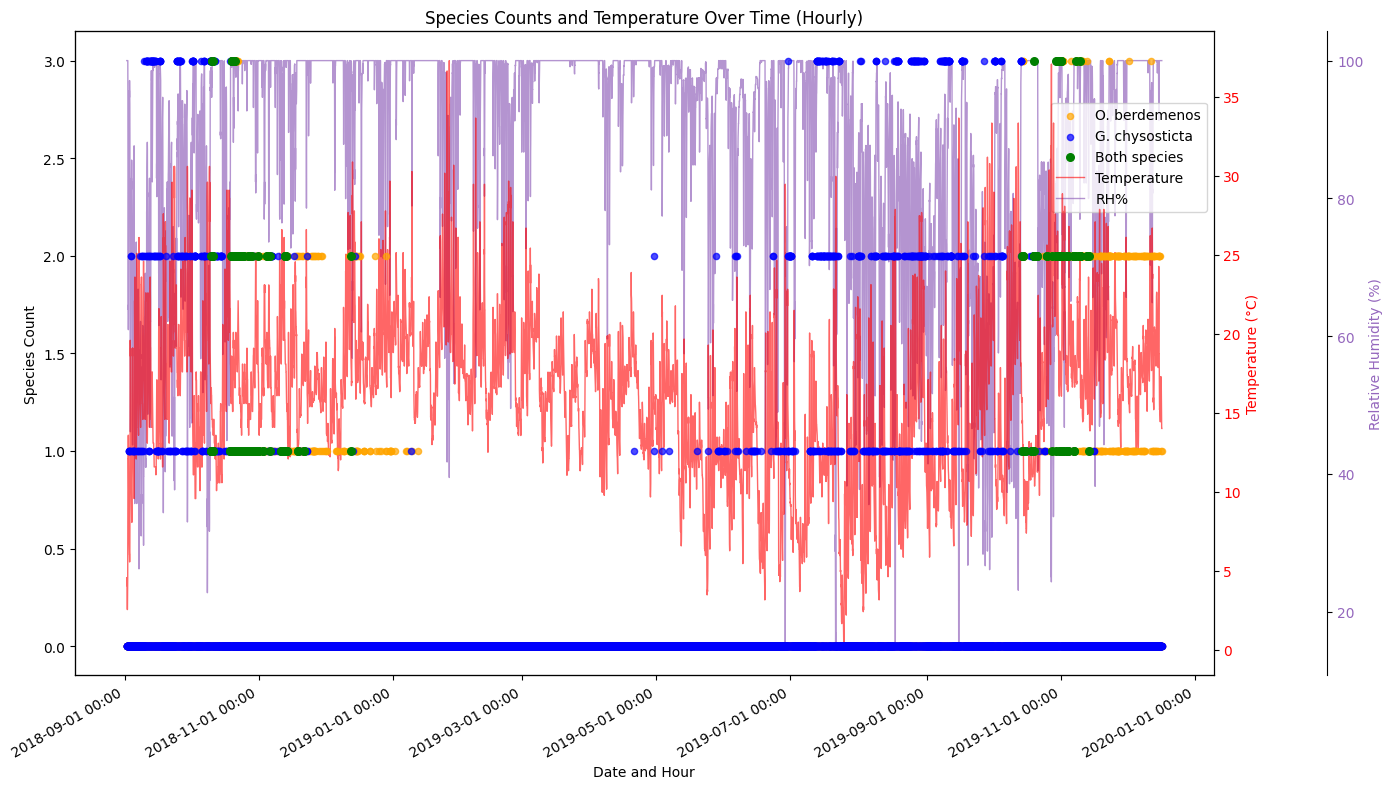

In [6]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

#df.index is the DateTime column after setting it as index, can still be accessed

# Plot species counts on primary y-axis
ax1.scatter(df.index, df['Oreobates berdemenos'], 
            color='orange', label='O. berdemenos', s=20, alpha=0.7, zorder=10)
ax1.scatter(df.index, df['Gastrotheca chysosticta'], 
            color='blue', label='G. chysosticta', s=20, alpha=0.7, zorder=20)

# Find times where both species are present in the same hour
both_species_hourly = df[
    (df['Oreobates berdemenos'] > 0) & 
    (df['Gastrotheca chysosticta'] > 0)
]

# Plot green points for hours where both species are present
if len(both_species_hourly) > 0:
    ax1.scatter(both_species_hourly.index, both_species_hourly['Oreobates berdemenos'], 
                color='green', s=30, label='Both species', zorder=30)
    ax1.scatter(both_species_hourly.index, both_species_hourly['Gastrotheca chysosticta'], 
                color='green', s=30, label='', zorder=40)
    
ax1.set_xlabel('Date and Hour')
ax1.set_ylabel('Species Count', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create secondary y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(df.index, df['Temp'], 'r-', linewidth=1, alpha=0.6, label='Temperature', zorder=5)
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Third axis for RH%
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.10))
ax3.set_ylabel('Relative Humidity (%)', color='tab:purple')
ax3.tick_params(axis='y', labelcolor='tab:purple')
ax3.plot(df.index,
         df['RH%'],
         color='tab:purple', linestyle='-', linewidth=1, alpha=0.7, label='RH%',zorder=3)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines1 + lines2 +lines3, labels1 + labels2+labels3, loc='upper right',bbox_to_anchor = (1,0.9))

# Desired top-to-bottom order (edit this list: first = top/front)
axes_order = ['ax1', 'ax2', 'ax3']  # e.g. ['ax3','ax1','ax2'] to put ax3 on top

def _reorder_axes(event=None):
    ax_map = {'ax1': ax1, 'ax2': ax2, 'ax3': ax3}
    # Make all axis patches transparent so lower axes are visible
    for ax in ax_map.values():
        ax.set_facecolor('none')
        ax.patch.set_alpha(0)
    # Assign zorders: higher = on top
    # Enumerate from bottom to top so last in list gets highest zorder
    for z, name in enumerate(reversed(axes_order), start=1):
        ax_map[name].set_zorder(z)

# Defer reordering until after ax2/ax3 are created later in the cell
fig.canvas.mpl_connect('draw_event', _reorder_axes)

# # Limit to a shorter time window for better visualization with hourly data
# date_max = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=515)#
# date_min = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=520)#, 81 has lots of noise
# plt.xlim(date_min, date_max)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Species Counts and Temperature Over Time (Hourly)')
plt.tight_layout()
plt.show()

# NODE

**Here**:

$y(t) \sim Poisson (\lambda(t))$

Where $y_t$ is the discrete ‘call intensity’ at time t, and lambda is a continuous variable which is a function of the temp, rh%, hour, day of year.

**let:**

$\lambda(t) = exp(w^Th(t)+b)$ to ensure positive ($w$ and $b$ are learnable parameters)

and 

$\dot{h} = f_\theta(h(t),\mathbf{X(t)})$

where $f_\theta$ is a neural network, and $\mathbf{X(t)}$ is all the data (same species call history, other species call history, temp, rh%, hour, day of year).

$u_i(t) = \rho_i u_i(t-1)+y_i(t-1)$ for species i, encodes short term memory

In [7]:
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

@dataclass
class TrainHistory:
    epochs: list = field(default_factory=list)
    nll_tr: list = field(default_factory=list)
    nll_va: list = field(default_factory=list)
    snaps_every: int = 100
    snaps_tr: dict = field(default_factory=dict)  # epoch -> lam_train snapshot (tensor [T_train])
    snaps_va: dict = field(default_factory=dict)  # epoch -> lam_val   snapshot (tensor [T_val])

def plot_training_curves(history: TrainHistory):
    plt.figure(figsize=(7,3))
    plt.plot(history.epochs, history.nll_tr, label="Train NLL")
    plt.plot(history.epochs, history.nll_va, label="Val NLL")
    plt.xlabel("Epoch")
    plt.ylabel("Poisson NLL (sum)")
    plt.title("Training & Validation NLL")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_expected_counts_snapshots(history: TrainHistory, ytr, yva, last_n=200):
    """
    Shows observed vs expected counts snapshots (train/val) for the last `last_n` hours
    at each logged epoch (e.g., 100, 200, ...).
    """
    # Train
    if len(ytr) > 0:
        plt.figure(figsize=(9,3))
        idx0 = max(0, len(ytr)-last_n)
        plt.plot(range(idx0, len(ytr)), ytr[idx0:].cpu().numpy(), label="Observed (train)", linewidth=1.5)
        for ep, lam in history.snaps_tr.items():
            lam_np = lam.numpy()
            plt.plot(range(idx0, len(ytr)), lam_np[idx0:], alpha=0.5, label=f"λ̂ train @ ep{ep}")
        plt.xlabel("Hour (train index)")
        plt.ylabel("Counts / Expected")
        plt.title(f"Train: observed vs λ̂ snapshots (last {len(ytr)-idx0} h)")
        plt.legend(ncol=2, fontsize=8)
        plt.tight_layout()
        plt.show()

    # Val
    if len(yva) > 0 and len(history.snaps_va) > 0:
        plt.figure(figsize=(9,3))
        idx0 = max(0, len(yva)-last_n)
        plt.plot(range(idx0, len(yva)), yva[idx0:].cpu().numpy(), label="Observed (val)", linewidth=1.5)
        for ep, lam in history.snaps_va.items():
            lam_np = lam.numpy()
            plt.plot(range(idx0, len(yva)), lam_np[idx0:], alpha=0.5, label=f"λ̂ val @ ep{ep}")
        plt.xlabel("Hour (val index)")
        plt.ylabel("Counts / Expected")
        plt.title(f"Val: observed vs λ̂ snapshots (last {len(yva)-idx0} h)")
        plt.legend(ncol=2, fontsize=8)
        plt.tight_layout()
        plt.show()

def plot_observed_vs_expected(model, Xtr, ytr, Xva, yva):
    with torch.no_grad():
        lam_tr = model(Xtr).cpu().numpy()
        lam_va = model(Xva).cpu().numpy()
    # Train
    plt.figure(figsize=(9,3))
    plt.plot(ytr.cpu().numpy(), label="Observed (train)")
    plt.plot(lam_tr, label="λ̂ (train)")
    plt.xlabel("Hour (train)")
    plt.ylabel("Counts / Expected")
    plt.title("Observed vs Expected (Train)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Val
    plt.figure(figsize=(9,3))
    plt.plot(yva.cpu().numpy(), label="Observed (val)")
    plt.plot(lam_va, label="λ̂ (val)")
    plt.xlabel("Hour (val)")
    plt.ylabel("Counts / Expected")
    plt.title("Observed vs Expected (Val)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_local_jacobian_traces(model, X, feat_names, sel_feats=None, stride=6):
    """
    Compute local Jacobians at times 0, stride, 2*stride,... and plot per-feature traces.
    We summarize ∑_i ∂ḣ_i/∂x_k and ∂ḷ/∂x_k (as in the fixed local_jacobians).
    """
    if sel_feats is None:
        sel_feats = feat_names  # plot all
    idxs = list(range(0, X.shape[0], stride))
    J_h_mat = []
    J_lam_mat = []
    for t in idxs:
        J_h, J_lam = local_jacobians(model, X, t)
        J_h_mat.append(J_h)
        J_lam_mat.append(J_lam)
    J_h_mat = np.stack(J_h_mat, axis=0)   # [T', d_x]
    J_lam_mat = np.stack(J_lam_mat, axis=0)

    # Plot per selected feature
    for fname in sel_feats:
        k = feat_names.index(fname)
        plt.figure(figsize=(8,2.7))
        plt.plot(idxs, J_h_mat[:, k], label="∑_i ∂ḣ_i/∂x_k")
        plt.plot(idxs, J_lam_mat[:, k], label="∂ḷ/∂x_k", alpha=0.8)
        plt.xlabel("Time index")
        plt.title(f"Local Jacobian traces: {fname}")
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_pathwise_effect_timeseries(model, X, feat_names, k, delta, window=6, stride=3):
    """
    Slide a window, perturb feature k by `delta` within each window,
    and plot Δ expected counts per window versus the start time.
    """
    T = X.shape[0]
    starts = list(range(0, max(T - window, 1), stride))
    dC_vals = []
    for s in starts:
        dC = pathwise_sensitivity(model, X, k, delta, start_idx=s, horizon=window)
        dC_vals.append(dC)
    plt.figure(figsize=(8,2.7))
    plt.plot(starts, dC_vals, marker='o')
    plt.axhline(0.0, color='k', linewidth=1)
    plt.xlabel("Window start (index)")
    plt.ylabel("Δ expected counts")
    plt.title(f"Pathwise effect: {feat_names[k]} (Δ={delta}, window={window}h)")
    plt.tight_layout()
    plt.show()

def plot_global_importance_bars(model, X, feat_names, spec):
    """
    `spec` is a list of tuples: [(feature_name, delta, window, stride), ...]
    Produces a bar chart with mean ± std of Δ expected counts across windows.
    """
    means, stds, labels = [], [], []
    for fname, delta, window, stride in spec:
        k = feat_names.index(fname)
        m, s, nW = global_importance(model, X, k, delta, horizon=window, stride=stride)
        means.append(m); stds.append(s); labels.append(f"{fname}\nΔ={delta}, W={window}")
    x = np.arange(len(labels))
    plt.figure(figsize=(max(6, 1.5*len(labels)), 3))
    plt.bar(x, means, yerr=stds, capsize=4)
    plt.axhline(0, color='k', linewidth=1)
    plt.xticks(x, labels, rotation=20, ha='right')
    plt.ylabel("Mean Δ expected counts")
    plt.title("Global variable importance (mean ± std across windows)")
    plt.tight_layout()
    plt.show()


In [8]:
# ============================================================
# Neural ODE-style hourly Poisson model for call intensities
# - Latent state h_t with residual dynamics (Euler step per hour)
# - Positive rate lambda_t = softplus(W h_t + b)
# - Poisson likelihood on hourly counts
# - Causal "memory" features for self and cross species (no leakage)
# ============================================================



import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


# ----------------------------
# Config (edit as needed)
# ----------------------------
CFG = {
    "timestamp_col": "DateTime",
    "target_col": "Oreobates berdemenos",      # target species hourly counts
    "other_col": "Gastrotheca chysosticta",       # other species hourly counts (as driver)
    "temp_col": "Temp",
    "rh_col": "RH%",
    "use_self_memory": True,
    "use_cross_memory": True,
    "tau_self_hours": 6.0,    # memory time-scale for target (hours)
    "tau_cross_hours": 6.0,   # memory time-scale for other (hours)
    "hidden_dim": 16,         # latent state dimension
    "mlp_width": 64,
    "mlp_depth": 2,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "max_epochs": 800,
    "print_every": 100,
    "grad_clip": 1.0,
    "val_frac": 0.2,          # time-based holdout at the end
    "seed": 42,
}

torch.manual_seed(CFG["seed"])
np.random.seed(CFG["seed"])

# ------------------------------------------------------------
# 1) Feature engineering: cyclical time + exponential memories
# ------------------------------------------------------------
def add_cyclical_time_features(df, ts_col):
    """Adds sin/cos time-of-day and sin/cos day-of-year."""
    if ts_col not in df.columns:
        df[ts_col] = df.index
    ts = pd.to_datetime(df[ts_col])
    # Time of day in [0, 24)
    hod = ts.dt.hour + ts.dt.minute/60.0
    tod_rad = 2*np.pi * (hod / 24.0)
    df["tod_sin"] = np.sin(tod_rad)
    df["tod_cos"] = np.cos(tod_rad)
    # Day of year (1..365)
    doy = ts.dt.dayofyear
    doy_rad = 2*np.pi * (doy / 365.0) 
    df["doy_sin"] = np.sin(doy_rad)
    df["doy_cos"] = np.cos(doy_rad)
    return df

def add_exponential_memory(df, count_col, out_col, tau_hours):
    """
    Adds an exponential memory feature u_t = rho * u_{t-1} + y_{t-1} (causal),
    where rho = exp(-1/tau_hours). Uses past counts only (no leakage).
    """
    rho = float(np.exp(-1.0 / max(tau_hours, 1e-6)))
    y = df[count_col].values.astype(float)
    u = np.zeros_like(y, dtype=float)
    # u_t depends on y_{t-1}, start from t=1
    for t in range(1, len(y)):
        u[t] = rho * u[t-1] + y[t-1]
    df[out_col] = u
    return df

def standardize_train_apply(train_s, test_s):
    """Return standardized train and test series and (mean, std)"""
    mean = float(train_s.mean())
    std = float(train_s.std(ddof=0)) if float(train_s.std(ddof=0)) > 0 else 1.0
    return ( (train_s - mean)/std, (test_s - mean)/std, mean, std )

# ------------------------------------------------------------
# 2) Prepare data from a single DataFrame `df`
#    Assumes hourly regular sampling; sort by timestamp just in case.
# ------------------------------------------------------------
def prepare_dataset(df, cfg=CFG):
    # Ensure sorted by time
    df = df.sort_values(cfg["timestamp_col"]).reset_index(drop=True)

    # Cyclical time
    df = add_cyclical_time_features(df, cfg["timestamp_col"])

    # Exponential memories (causal)
    if cfg["use_self_memory"]:
        df = add_exponential_memory(df, cfg["target_col"], "u_self", cfg["tau_self_hours"])
    else:
        df["u_self"] = 0.0

    if cfg["use_cross_memory"]:
        df = add_exponential_memory(df, cfg["other_col"], "u_cross", cfg["tau_cross_hours"])
    else:
        df["u_cross"] = 0.0

    # Build design matrix X_t and target y_t
    feat_cols = [
        "tod_sin", "tod_cos",
        "doy_sin", "doy_cos",
        cfg["temp_col"], cfg["rh_col"],
        "u_self", "u_cross"
    ]
    X = df[feat_cols].copy()
    y = df[cfg["target_col"]].astype(float).copy()

    # Time-based split (no shuffling)
    n = len(df)
    n_val = int(np.floor(cfg["val_frac"] * n))
    n_train = n - n_val
    train_idx = np.arange(0, n_train) #train on first 80% of data - future prediction
    val_idx = np.arange(n_train, n) #validate on last 20%

    X_train, X_val = X.iloc[train_idx].reset_index(drop=True), X.iloc[val_idx].reset_index(drop=True)
    y_train, y_val = y.iloc[train_idx].reset_index(drop=True), y.iloc[val_idx].reset_index(drop=True)

    # Standardize continuous covariates (leave sin/cos as is)
    keep = ["tod_sin","tod_cos","doy_sin","doy_cos"]
    scale = [cfg["temp_col"], cfg["rh_col"], "u_self", "u_cross"]

    Xtr = X_train.copy()
    Xva = X_val.copy()
    scalers = {}
    for c in scale:
        Xtr[c], Xva[c], mu, sd = standardize_train_apply(X_train[c], X_val[c])
        scalers[c] = (mu, sd)

    # Tensors
    Xtr_t = torch.tensor(Xtr.values, dtype=torch.float32)
    Xva_t = torch.tensor(Xva.values, dtype=torch.float32)
    ytr_t = torch.tensor(y_train.values, dtype=torch.float32)
    yva_t = torch.tensor(y_val.values, dtype=torch.float32)

    meta = {
        "feat_cols": feat_cols,
        "scalers": scalers,
        "train_idx": train_idx,
        "val_idx": val_idx,
        "n_train": n_train,
        "n_val": n_val,
        "keep_cols_no_scale": keep,
        "val_frac": cfg["val_frac"],
    }
    return Xtr_t, ytr_t, Xva_t, yva_t, meta

# ------------------------------------------------------------
# 3) NODE-style model (Euler step per hour)
#    x_t     = covariates at hour t (dim d_x)
#    f([h_t, x_t]) = NN([h_t, x_t]) = time derivative of h (dim d_h)
#    h_t     = latent state (dim d_h)
#    h_{t+1} = h_t + f([h_t, x_t])          (Δ = 1 hour)
#    λ_t     = softplus(W h_t + b)           (expected count in hour t)
#    y_t ~ Poisson(λ_t)
# ------------------------------------------------------------
class NodeHourly(nn.Module): # neural network class, input is nn.Module, output is the prediction of lambda over the whole time series
    """Neural ODE-style hourly Poisson model
    - Latent state h_t with residual dynamics (Euler step per hour)
    - Positive rate lambda_t = softplus(W h_t + b)
    - Poisson likelihood on hourly counts
    - Causal "memory" features for self and cross species (no leakage)
    """
    def __init__(self, d_x, d_h=16, mlp_width=64, mlp_depth=2):
        super().__init__()
        layers = []
        in_dim = d_x + d_h
        for i in range(mlp_depth): #number of hidden layers
            layers.append(nn.Linear(in_dim if i==0 else mlp_width, mlp_width)) #first layer input dim is d_x + d_h, rest are mlp_width
            layers.append(nn.Tanh())
        layers.append(nn.Linear(mlp_width, d_h))# output layer to d_h
        self.f = nn.Sequential(*layers)         # add layers to a sequential model (dont need to define forward, just call self.f(input)) - get dh/dt which is dimension d_h

        self.readout = nn.Linear(d_h, 1)        # get scalar input to exp for lambda from h_t
        self.bias = nn.Parameter(torch.tensor([0.1]))  # small positive bias in the exp
        # optional learned initial state (one global h_0)
        self.h0 = nn.Parameter(torch.zeros(d_h))

    def step(self, h_t, x_t):
        # One Euler step; Δ=1 hour
        dh = self.f(torch.cat([h_t, x_t], dim=-1)) # compute dh/dt = f([h_t, x_t])
        h_next = h_t + dh # Euler step: h_{t+1} = h_t + dh as delta is 1 hour
        lam_t = torch.nn.functional.softplus(self.readout(h_t) + self.bias)  # convert h_t into scalar h_t, then add to bias and exp to get positive rate lambda estimate
        return h_next, lam_t.squeeze(-1)

    def forward(self, X):  # X: [T, d_x]
        T = X.shape[0] # number of time steps
        h = self.h0.unsqueeze(0)  # initial hidden state, shape [1, d_h]
        lam_list = [] #list of lambdas, lambda(t) is the expected count at time t
        for t in range(T): #for all times
            h, lam_t = self.step(h, X[t:t+1, :])# update h and get lambda(t)
            lam_list.append(lam_t) # store lambda(t)
        lam = torch.stack(lam_list, dim=0)    # list of lambdas at all times, shape [T]
        return lam

# ------------------------------------------------------------
# 4) Training & evaluation utilities
# ------------------------------------------------------------
def poisson_nll(lam, y, eps=1e-8):
    """
    Poisson negative log-likelihood (sum over time),
    dropping the constant log(y!) term.
    lam: [T] expected counts (must be >0) is float
    y:   [T] observed counts, is integer
    """
    return torch.sum(lam - y * torch.log(lam + eps))


def fit_model(Xtr, ytr, Xva, yva, cfg=CFG):
    model = NodeHourly(d_x=Xtr.shape[1], d_h=cfg["hidden_dim"],
                       mlp_width=cfg["mlp_width"], mlp_depth=cfg["mlp_depth"])
    opt = optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    best_state = None
    best_val = float("inf")
    hist = TrainHistory(snaps_every=cfg["print_every"])

    for epoch in range(1, cfg["max_epochs"]+1):
        model.train()
        opt.zero_grad()
        lam_tr = model(Xtr)
        nll_tr = poisson_nll(lam_tr, ytr)
        nll_tr.backward()
        nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
        opt.step()

        # Validation
        model.eval()
        with torch.no_grad():
            lam_va = model(Xva)
            nll_va = poisson_nll(lam_va, yva)

        # Log
        hist.epochs.append(epoch)
        hist.nll_tr.append(float(nll_tr.item()))
        hist.nll_va.append(float(nll_va.item()))
        if (epoch % cfg["print_every"] == 0) or (epoch == 1) or (epoch == cfg["max_epochs"]):
            print(f"Epoch {epoch:4d} | NLL train={nll_tr.item():.2f} | NLL val={nll_va.item():.2f}")
            # store snapshots of expected calls
            hist.snaps_tr[epoch] = lam_tr.detach().cpu().clone()
            hist.snaps_va[epoch] = lam_va.detach().cpu().clone()

        # Track best
        if nll_va.item() < best_val:
            best_val = nll_va.item()
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model, hist

# def fit_model(Xtr, ytr, Xva, yva, cfg=CFG):
#     model = NodeHourly(d_x=Xtr.shape[1], d_h=cfg["hidden_dim"],
#                        mlp_width=cfg["mlp_width"], mlp_depth=cfg["mlp_depth"])
#     opt = optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

#     best_state = None
#     best_val = float("inf")

#     for epoch in range(1, cfg["max_epochs"]+1):
#         model.train()
#         opt.zero_grad()
#         lam_tr = model(Xtr)
#         nll_tr = poisson_nll(lam_tr, ytr)
#         nll_tr.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
#         opt.step()

#         # Validation
#         model.eval()
#         with torch.no_grad():
#             lam_va = model(Xva)
#             nll_va = poisson_nll(lam_va, yva)

#         if nll_va.item() < best_val:
#             best_val = nll_va.item()
#             best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

#         if epoch % cfg["print_every"] == 0 or epoch == 1:
#             print(f"Epoch {epoch:4d} | NLL train={nll_tr.item():.2f} | NLL val={nll_va.item():.2f}")

#     # Load best params
#     if best_state is not None:
#         model.load_state_dict(best_state)
#     model.eval()
#     return model

# ------------------------------------------------------------
# 5) Interpretation helpers
#    (i) Local Jacobians at a time index
#    (ii) Pathwise sensitivity over a window
#    (iii) Global importance via perturbations
# ------------------------------------------------------------
def local_jacobians(model, X, t_idx):
    """
    Compute instantaneous sensitivities at time t_idx:

      J_h[k]      = sum_i ∂(ḣ_i)/∂x_k      (collapsed over latent dims for readability)
      J_lam[k]    = ∂(ḷ)/∂x_k = (dλ/dh) · (∂ḣ/∂x_k)

    Also see the commented return if you’d like the full matrix ∂ḣ/∂x (shape d_h × d_x).
    """
    # Inputs requiring grad
    x = X[t_idx:t_idx+1, :].clone().detach().requires_grad_(True)   # [1, d_x]
    h = model.h0.unsqueeze(0).clone().detach().requires_grad_(True) # [1, d_h]

    # Instantaneous latent derivative ḣ(h,x) and λ(h)
    dhdt = model.f(torch.cat([h, x], dim=-1)).squeeze(0)            # [d_h]
    lam  = torch.nn.functional.softplus(model.readout(h) + model.bias).squeeze()

    # dλ/dh  (row vector over latent dims)
    dlam_dh = torch.autograd.grad(lam, h, retain_graph=True)[0].squeeze(0)   # [d_h]

    # Full Jacobian ∂ḣ/∂x  (d_h × d_x), by looping over latent dims
    d_h = dhdt.numel()
    d_x = x.numel()
    J_dhdt_dx = torch.zeros(d_h, d_x, dtype=x.dtype)
    for i in range(d_h):
        # Gradient of scalar dhdt[i] w.r.t. x -> shape [1, d_x]
        gi = torch.autograd.grad(dhdt[i], x, retain_graph=True)[0][0]  # [d_x]
        J_dhdt_dx[i, :] = gi

    # Collapse over latent dims (sum) to mimic the earlier scalar summary per feature
    J_h = J_dhdt_dx.sum(dim=0).detach().cpu().numpy()                 # [d_x]

    # ∂(ḷ)/∂x_k = (dλ/dh) · (∂ḣ/∂x_k), do the dot product for each feature k
    J_lam = (dlam_dh.detach().unsqueeze(0) @ J_dhdt_dx).squeeze(0).cpu().numpy()  # [d_x]

    return J_h, J_lam
    # If you ever want the full matrix too, return J_dhdt_dx.detach().cpu().numpy() as a 3rd value.


def pathwise_sensitivity(model, X, k, delta, start_idx, horizon):
    """
    Counterfactual shift X[:,k] += delta over [start_idx, start_idx+horizon)
    Returns Δ expected counts over the window (sum of λ differences).
    """
    X_base = X.clone().detach()
    X_pert = X.clone().detach()
    a = int(start_idx)
    b = int(min(start_idx + horizon, X.shape[0]))
    X_pert[a:b, k] += delta

    with torch.no_grad():
        lam_base = model(X_base)
        lam_pert = model(X_pert)
        dC = (lam_pert[a:b] - lam_base[a:b]).sum().item()
    return dC

def global_importance(model, X, k, delta, horizon=6, stride=6):
    """
    Average Δ expected counts for covariate k across sliding windows.
    """
    T = X.shape[0]
    idxs = list(range(0, max(T - horizon, 1), stride))
    vals = [pathwise_sensitivity(model, X, k, delta, i, horizon) for i in idxs]
    return float(np.mean(vals)), float(np.std(vals)), len(vals)

# ------------------------------------------------------------
# 6) Example: end-to-end using your df
# ------------------------------------------------------------
def run_training_on_df(df, cfg=CFG):
    Xtr, ytr, Xva, yva, meta = prepare_dataset(df.copy(), cfg=cfg)
    print(f"Train length: {len(Xtr)}, Val length: {len(Xva)}")
    model = fit_model(Xtr, ytr, Xva, yva, cfg=cfg)

    # Simple eval: report average train/val NLL
    with torch.no_grad():
        nll_tr = poisson_nll(model(Xtr), ytr).item()
        nll_va = poisson_nll(model(Xva), yva).item()
    print(f"\nBest model Poisson NLL  |  Train: {nll_tr:.2f}  Val: {nll_va:.2f}")

    # Interpret: local Jacobians at the middle of train segment
    t_mid = len(Xtr)//2
    J_h, J_lam = local_jacobians(model, Xtr, t_mid)
    print("\nLocal Jacobian at train midpoint:")
    print("  features:", meta["feat_cols"])
    print("  d(dh/dt)/dx_k:", np.round(J_h, 4))
    print("  d(dλ/dt)/dx_k:", np.round(J_lam, 4))

    # Interpret: pathwise & global importance for a couple of features
    # Example: +2°C and +0.5 memory bump, over 6-hour windows
    k_temp = meta["feat_cols"].index(cfg["temp_col"])
    k_memB = meta["feat_cols"].index("u_cross")
    dC_temp = pathwise_sensitivity(model, Xtr, k_temp, delta=2.0, start_idx=t_mid, horizon=6)
    dC_memB = pathwise_sensitivity(model, Xtr, k_memB, delta=0.5, start_idx=t_mid, horizon=6)
    print(f"\nPathwise ΔE[counts] over 6h at midpoint:")
    print(f"  Temp +2°C:   {dC_temp:.3f}")
    print(f"  Cross mem +0.5: {dC_memB:.3f}")

    mean_imp_temp, std_imp_temp, nW = global_importance(model, Xtr, k_temp, delta=2.0, horizon=6, stride=6)
    mean_imp_memB, std_imp_memB, _ = global_importance(model, Xtr, k_memB, delta=0.5, horizon=6, stride=6)
    print(f"\nGlobal importance (avg over {nW} windows of 6h):")
    print(f"  Temp +2°C:   mean {mean_imp_temp:.3f} ± {std_imp_temp:.3f}")
    print(f"  Cross mem +0.5: mean {mean_imp_memB:.3f} ± {std_imp_memB:.3f}")

    return model, (Xtr, ytr, Xva, yva), meta


Epoch    1 | NLL train=1114447232.00 | NLL val=33019780.00
Epoch  100 | NLL train=76511216.00 | NLL val=26251900.00
Epoch  200 | NLL train=1172683264.00 | NLL val=7539438.00
Epoch  300 | NLL train=344393280.00 | NLL val=10693780.00
Epoch  400 | NLL train=77845016.00 | NLL val=89856392.00
Epoch  500 | NLL train=79198544.00 | NLL val=26360904.00
Epoch  600 | NLL train=240004384.00 | NLL val=22130996.00
Epoch  700 | NLL train=75375408.00 | NLL val=21648240.00
Epoch  800 | NLL train=75641296.00 | NLL val=27826756.00


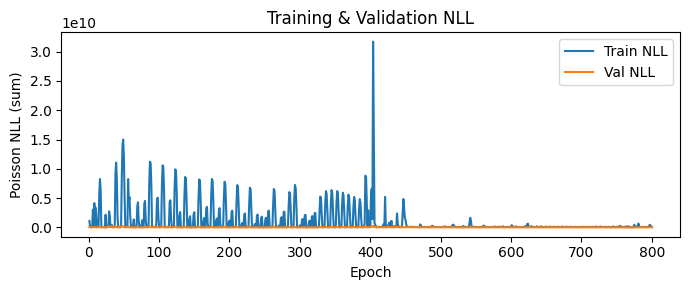

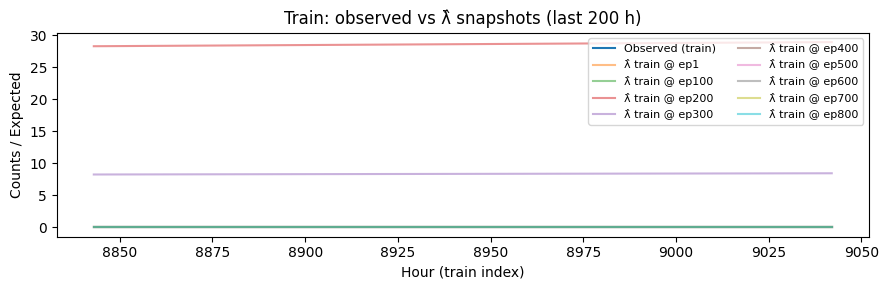

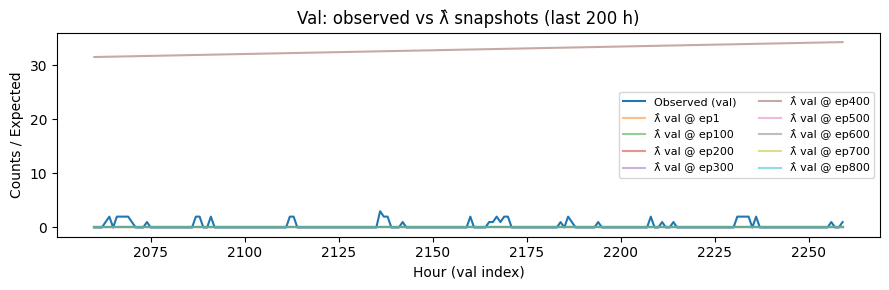

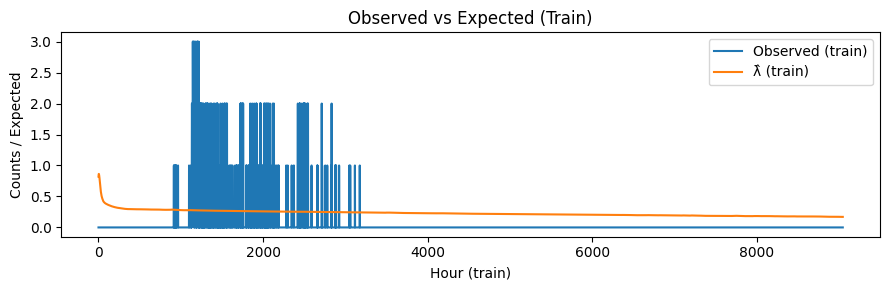

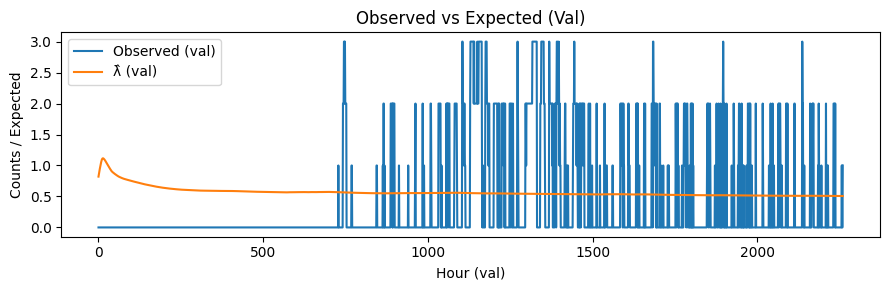

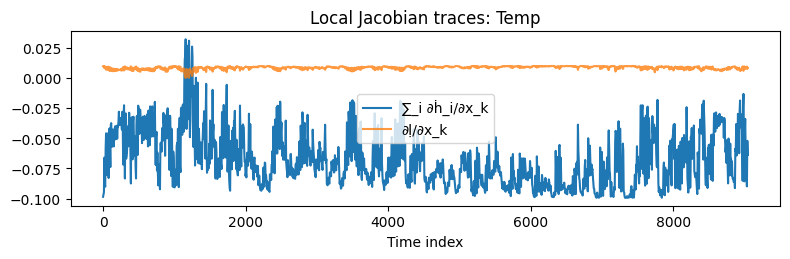

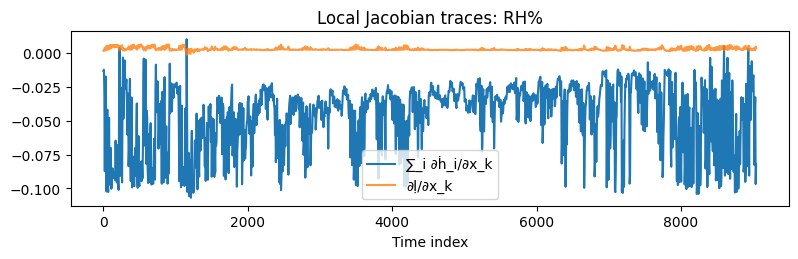

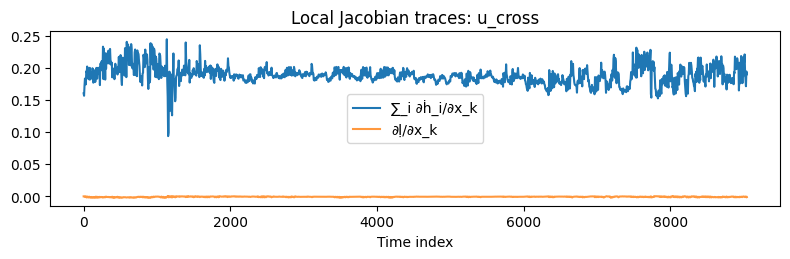

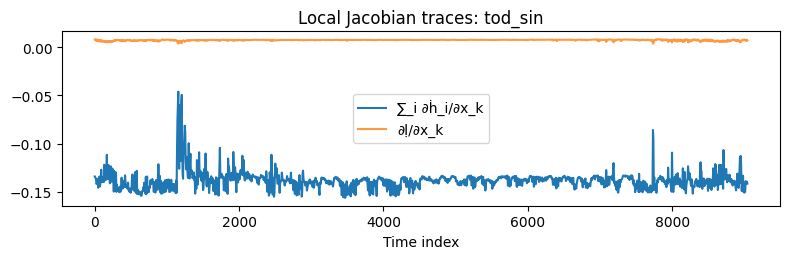

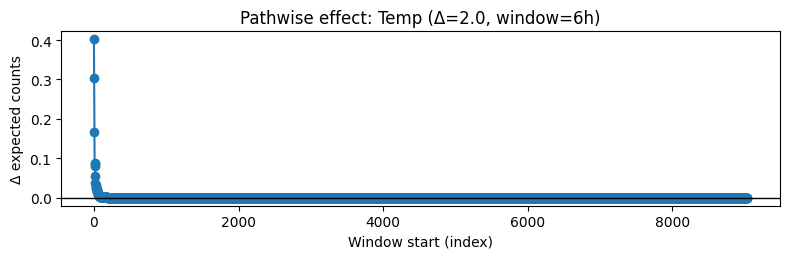

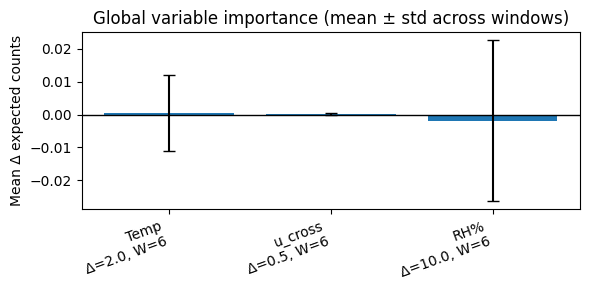

In [29]:
# Train with logging
Xtr, ytr, Xva, yva, meta = prepare_dataset(df.copy(), cfg=CFG)
model, history = fit_model(Xtr, ytr, Xva, yva, cfg=CFG)

# 1) Curves & snapshots
plot_training_curves(history)
plot_expected_counts_snapshots(history, ytr, yva, last_n=200)

# 2) Observed vs expected (final model)
plot_observed_vs_expected(model, Xtr, ytr, Xva, yva)

# 3) Local Jacobian traces for a few features
feat_names = meta["feat_cols"]
sel_feats = [CFG["temp_col"], CFG["rh_col"], "u_cross", "tod_sin"]
plot_local_jacobian_traces(model, Xtr, feat_names, sel_feats=sel_feats, stride=6)

# 4) Pathwise effect timeseries
k_temp = feat_names.index(CFG["temp_col"])
plot_pathwise_effect_timeseries(model, Xtr, feat_names, k=k_temp, delta=2.0, window=6, stride=3)

# 5) Global importance bars
spec = [
    (CFG["temp_col"],  2.0, 6, 6),  # Temp +2°C, 6h windows
    ("u_cross",        0.5, 6, 6),  # Cross memory +0.5
    (CFG["rh_col"],   10.0, 6, 6),  # RH +10% (assuming standardized, interpret accordingly)
]
plot_global_importance_bars(model, Xtr, feat_names, spec)


In [14]:


# ----------------------------
# Usage:
#   Ensure `df` exists with columns in CFG.
#   Then run:
#       model, data, meta = run_training_on_df(df, CFG)
# ----------------------------

model, data, meta = run_training_on_df(df, CFG)

Train length: 9043, Val length: 2260
Epoch    1 | NLL train=1114447232.00 | NLL val=33019780.00
Epoch  100 | NLL train=76511216.00 | NLL val=26251900.00
Epoch  200 | NLL train=1172683264.00 | NLL val=7539438.00
Epoch  300 | NLL train=344393280.00 | NLL val=10693780.00
Epoch  400 | NLL train=77845016.00 | NLL val=89856392.00
Epoch  500 | NLL train=79198544.00 | NLL val=26360904.00
Epoch  600 | NLL train=240004384.00 | NLL val=22130996.00
Epoch  700 | NLL train=75375408.00 | NLL val=21648240.00
Epoch  800 | NLL train=75641296.00 | NLL val=27826756.00

Best model Poisson NLL  |  Train: 25522036.00  Val: 3970826.00


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 16)